In [81]:
import gmsh
import meshio
from nodes import Node
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

from nodes import Node  # Asegúrate de tener esta clase
from LSTL import LST    # Tu clase LST

In [82]:
input_file = "T4.geo"
output_file = "mallas/malla_LST33.msh"
titulo = "Caso LST"

In [83]:
def reorder_triangle6(node_ids, nodes):
    """
    Asegura que los nodos del triángulo de 6 nodos estén en orden:
    [v1, v2, v3, m12, m23, m31]
    según convención FEM (Gmsh puede usar [v1, v2, v3, m23, m31, m12])
    """

    # Coordenadas de los 6 nodos
    coords = np.array([[nodes[nid - 1].x, nodes[nid - 1].y] for nid in node_ids])

    # Los primeros tres son los vértices
    v1, v2, v3 = coords[:3]

    # Los últimos tres son los nodos de borde (midside)
    mids = coords[3:]

    # Función auxiliar: distancia al segmento
    def is_between(p, a, b):
        mid = 0.5 * (a + b)
        return np.linalg.norm(p - mid) < 1e-8  # tolerancia

    # Identifica cuál nodo es m12, m23, m31
    m12 = m23 = m31 = None
    for i, p in enumerate(mids):
        if is_between(p, v1, v2):
            m12 = node_ids[3 + i]
        elif is_between(p, v2, v3):
            m23 = node_ids[3 + i]
        elif is_between(p, v3, v1):
            m31 = node_ids[3 + i]

    if None in (m12, m23, m31):
        print(f"⚠️ Error reordenando nodos LST: {node_ids}")
        return node_ids  # fallback

    # Devuelve orden correcto
    return [node_ids[0], node_ids[1], node_ids[2], m12, m23, m31]


In [84]:
mesh = meshio.read(output_file)
nodes = [Node(i + 1, x, y) for i, (x, y, _) in enumerate(mesh.points)]

lst_elements = []
for cell_block in mesh.cells:
    if cell_block.type == "triangle6":
        for i, node_ids in enumerate(cell_block.data):
            node_ids = [int(id) + 1 for id in node_ids]  # pasar a base 1
            ordered_ids = reorder_triangle6(node_ids, nodes)
            lst_elements.append(LST(i + 1, ordered_ids))

        break

boundary_nodes = {1: set(), 2: set(), 3: set(), 4: set()}
if "line3" in mesh.cell_data_dict["gmsh:physical"]:
    for cell_block in mesh.cells:
        if cell_block.type == "line3":
            physical_ids = mesh.cell_data_dict["gmsh:physical"]["line3"]
            for line, phys_id in zip(cell_block.data, physical_ids):
                if phys_id in boundary_nodes:
                    for node_id in line:
                        boundary_nodes[phys_id].add(int(node_id) + 1)

for node in nodes:
    node.boundary_label = []
    for label_id, node_set in boundary_nodes.items():
        if node.id in node_set:
            node.boundary_label.append("Dirichlet Boundary")

# Verificación visual
print(boundary_nodes)

elements= lst_elements



{1: {1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61}, 2: {2, 3, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118}, 3: {128, 129, 130, 3, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 146, 4, 119, 120, 121, 122, 123, 124, 125, 126, 127}, 4: {1, 4, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [85]:
#Ahora debo calcular la solucion u
alpha = 3

for node in nodes:
    node.solve_u(alpha)

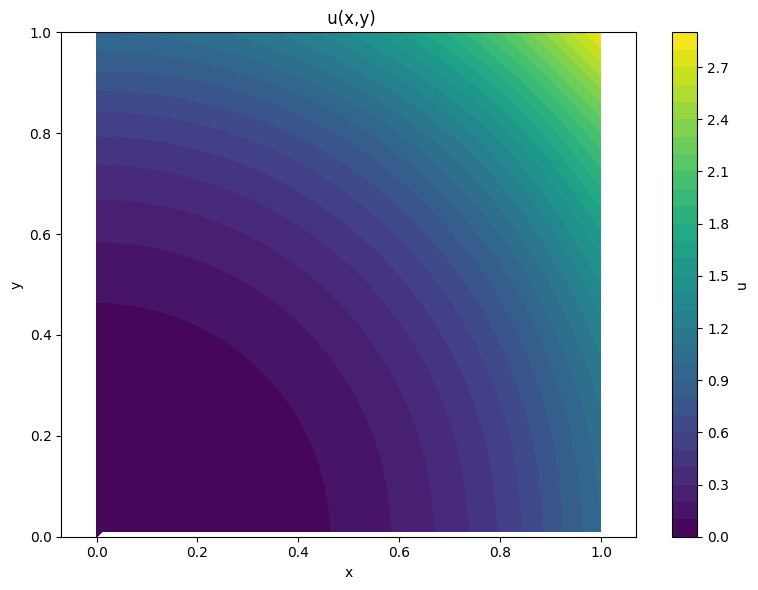

In [86]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.tri import Triangulation

from scipy.interpolate import griddata
def plot_u_field(nodes, elements, use_attr="u", mode="colormap"):
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    z = np.array([getattr(node, use_attr) for node in nodes])
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    if mode == "colormap":
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((x, y), z, (X, Y), method='cubic')
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='viridis')
        plt.colorbar(label=use_attr)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f" {use_attr}(x,y)")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig(f"LST_{use_attr}_{mode}_plot.png", dpi=300)
        plt.show()

plot_u_field(nodes, elements, use_attr="u", mode="colormap")

In [87]:
#Bien, ahora es nesesario ensamblar la stifnes matrix de cada elemento CST
from solve import Solve

Estructure = Solve(nodes, elements, alpha)

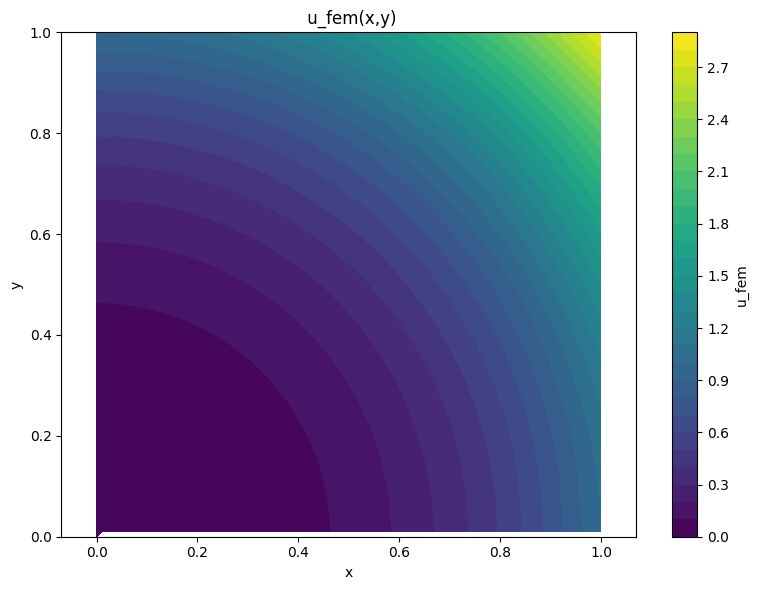

In [88]:
#Conozco todos lo que esta en la frontera diritchlet
Estructure.solve_matrix()
plot_u_field(nodes, elements, use_attr="u_fem", mode="colormap")


In [89]:
def plot_relative_error(nodes, elements, mode="colormap"):
    """
    Visualiza el error relativo |u_fem - u| / |u| mediante:
    - 'colormap' → mapa de color interpolado en 2D
    """
    # Extraer datos de nodos
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])

    # Evitar división por cero
    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) 

    # Conectividad de elementos
    triangles = np.array([[nid - 1 for nid in elem.node_ids] for elem in elements])
    #tri = Triangulation(x, y, triangles)

    if mode == "colormap":
        # Interpolación sobre malla regular
        xi = np.linspace(min(x), max(x), 100)
        yi = np.linspace(min(y), max(y), 100)
        X, Y = np.meshgrid(xi, yi)
        Z = griddata((x, y), error_rel, (X, Y), method='cubic')

        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=30, cmap='plasma')
        plt.colorbar(label="Error relativo")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Error relativo |u - u_h|")
        plt.axis("equal")
        plt.tight_layout()
        plt.savefig("LST_relative_error_colormap.png", dpi=300)
        plt.show()

    else:
        raise ValueError("Modo no válido. Usa 'colormap'.")

    # Imprimir resumen numérico
    print(f"Máximo error relativo: {np.max(error_rel):.2e}")
    print(f"Promedio error relativo: {np.mean(error_rel):.2e}")
    print(f"Mínimo error relativo: {np.min(error_rel):.2e}")

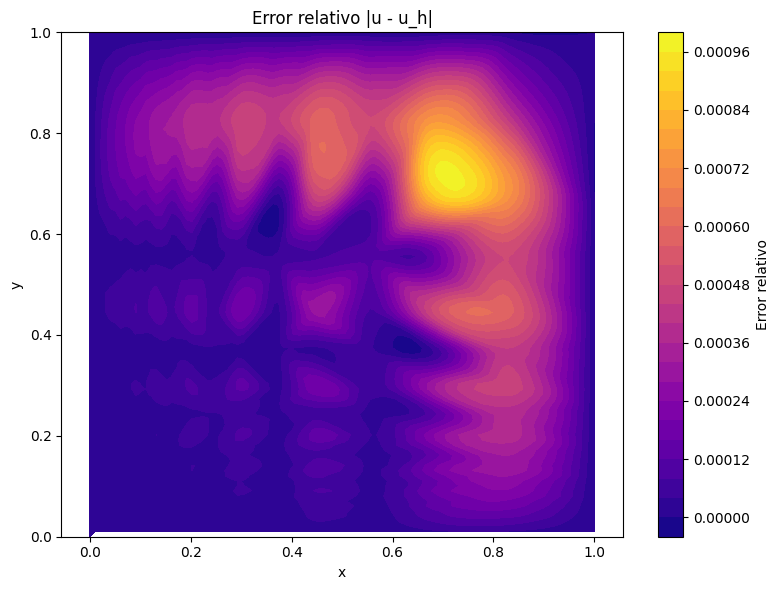

Máximo error relativo: 7.86e-04
Promedio error relativo: 7.36e-06
Mínimo error relativo: 0.00e+00


In [90]:
# Visualizar el error relativo
plot_relative_error(nodes, lst_elements, mode="colormap")